# Instance Detection with RetinaNet

We are going to implement [RetinaNet by Lin et al., 2017](https://arxiv.org/abs/1708.02002) for [COCO dataset](http://cocodataset.org/) instance detection.

## Import the required libraries

In [1]:
import tempfile

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import fastestimator as fe

In [2]:
#training parameters
batch_size = 8
epochs = 12 

max_train_steps_per_epoch = None
max_eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()

## Step 1 - Data and `Pipeline` preparation

### Load data

The `class.json` includes a map for the class number and what object the number corresponds to.

In [3]:
import json

with open('class.json', 'r') as f:
    class_map = json.load(f)

We call our `mscoco` data API to obtain the training and validation set:
* 118287 images for training
* 5000 images for validation

In [4]:
from fastestimator.dataset.data import mscoco

train_ds, eval_ds = mscoco.load_data()
assert len(train_ds) == 118287
assert len(eval_ds) == 5000

### Generate Anchors

Anchors are predefined for each pixel in the feature map. In this apphub our backbone is ResNet-50, so we can precompute all the anchors we need for training.

In [5]:
def get_fpn_anchor_box(width: int, height: int):
    assert height % 32 == 0 and width % 32 == 0
    shapes = [(int(height / 8), int(width / 8))]  # P3
    num_pixel = [np.prod(shapes)]
    anchor_lengths = [32, 64, 128, 256, 512]
    for _ in range(4):  # P4 through P7
        shapes.append((int(np.ceil(shapes[-1][0] / 2)), int(np.ceil(shapes[-1][1] / 2))))
        num_pixel.append(np.prod(shapes[-1]))
    total_num_pixels = np.sum(num_pixel)
    anchorbox = np.zeros((9 * total_num_pixels, 4))
    anchor_length_multipliers = [2**(0.0), 2**(1 / 3), 2**(2 / 3)]
    aspect_ratios = [1.0, 2.0, 0.5]  #x:y
    anchor_idx = 0
    for shape, anchor_length in zip(shapes, anchor_lengths):
        p_h, p_w = shape
        base_y = 2**np.ceil(np.log2(height / p_h))
        base_x = 2**np.ceil(np.log2(width / p_w))
        for i in range(p_h):
            center_y = (i + 1 / 2) * base_y
            for j in range(p_w):
                center_x = (j + 1 / 2) * base_x
                for anchor_length_multiplier in anchor_length_multipliers:
                    area = (anchor_length * anchor_length_multiplier)**2
                    for aspect_ratio in aspect_ratios:
                        x1 = center_x - np.sqrt(area * aspect_ratio) / 2
                        y1 = center_y - np.sqrt(area / aspect_ratio) / 2
                        x2 = center_x + np.sqrt(area * aspect_ratio) / 2
                        y2 = center_y + np.sqrt(area / aspect_ratio) / 2
                        anchorbox[anchor_idx, 0] = x1
                        anchorbox[anchor_idx, 1] = y1
                        anchorbox[anchor_idx, 2] = x2 - x1
                        anchorbox[anchor_idx, 3] = y2 - y1
                        anchor_idx += 1
        if p_h == 1 and p_w == 1:  # the next level of 1x1 feature map is still 1x1, therefore ignore
            break
    return np.float32(anchorbox), np.int32(num_pixel) * 9

In [6]:
from fastestimator.op.numpyop import NumpyOp

class AnchorBox(NumpyOp):
    def __init__(self, width, height, inputs, outputs, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.anchorbox, _ = get_fpn_anchor_box(width, height)  # anchorbox is #num_anchor x 4

    def forward(self, data, state):
        target = self._generate_target(data)  # bbox is #obj x 5
        return np.float32(target)

    def _generate_target(self, bbox):
        object_boxes = bbox[:, :-1]  # num_obj x 4
        label = bbox[:, -1]  # num_obj x 1
        ious = self._get_iou(object_boxes, self.anchorbox)  # num_obj x num_anchor
        #now for each object in image, assign the anchor box with highest iou to them
        anchorbox_best_iou_idx = np.argmax(ious, axis=1)
        num_obj = ious.shape[0]
        for row in range(num_obj):
            ious[row, anchorbox_best_iou_idx[row]] = 0.99
        #next, begin the anchor box assignment based on iou
        anchor_to_obj_idx = np.argmax(ious, axis=0)  # num_anchor x 1
        anchor_best_iou = np.max(ious, axis=0)  # num_anchor x 1
        cls_gt = np.int32([label[idx] for idx in anchor_to_obj_idx])  # num_anchor x 1
        cls_gt[np.where(anchor_best_iou <= 0.4)] = -1  #background class
        cls_gt[np.where(np.logical_and(anchor_best_iou > 0.4, anchor_best_iou <= 0.5))] = -2  # ignore these examples
        #finally, calculate localization target
        single_loc_gt = object_boxes[anchor_to_obj_idx]  # num_anchor x 4
        gt_x1, gt_y1, gt_width, gt_height = np.split(single_loc_gt, 4, axis=1)
        ac_x1, ac_y1, ac_width, ac_height = np.split(self.anchorbox, 4, axis=1)
        dx1 = np.squeeze((gt_x1 - ac_x1) / ac_width)
        dy1 = np.squeeze((gt_y1 - ac_y1) / ac_height)
        dwidth = np.squeeze(np.log(gt_width / ac_width))
        dheight = np.squeeze(np.log(gt_height / ac_height))
        return np.array([dx1, dy1, dwidth, dheight, cls_gt]).T  # num_anchor x 5

    @staticmethod
    def _get_iou(boxes1, boxes2):
        """Computes the value of intersection over union (IoU) of two array of boxes.
        Args:
            box1 (array): first boxes in N x 4
            box2 (array): second box in M x 4
        Returns:
            float: IoU value in N x M
        """
        x11, y11, w1, h1 = np.split(boxes1, 4, axis=1)
        x21, y21, w2, h2 = np.split(boxes2, 4, axis=1)
        x12 = x11 + w1
        y12 = y11 + h1
        x22 = x21 + w2
        y22 = y21 + h2
        xmin = np.maximum(x11, np.transpose(x21))
        ymin = np.maximum(y11, np.transpose(y21))
        xmax = np.minimum(x12, np.transpose(x22))
        ymax = np.minimum(y12, np.transpose(y22))
        inter_area = np.maximum((xmax - xmin + 1), 0) * np.maximum((ymax - ymin + 1), 0)
        area1 = (w1 + 1) * (h1 + 1)
        area2 = (w2 + 1) * (h2 + 1)
        iou = inter_area / (area1 + area2.T - inter_area)
        return iou

### `Pipeline`

For our data pipeline, we resize the images such that the longer side is 512 pixels. We keep the aspect ratio the same as original image, so on the shorter side we pad zeros. The resized image is 512 by 512. For data augmentation we only flip the image horizontally. 

In [7]:
from albumentations import BboxParams

from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, LongestMaxSize, PadIfNeeded
from fastestimator.op.numpyop.univariate import Normalize, ReadImage, ToArray

pipeline = fe.Pipeline(
    train_data=train_ds,
    eval_data=eval_ds,
    batch_size=batch_size,
    ops=[
        ReadImage(inputs="image", outputs="image"),
        LongestMaxSize(512,
                       image_in="image",
                       image_out="image",
                       bbox_in="bbox",
                       bbox_out="bbox",
                       bbox_params=BboxParams("coco", min_area=1.0)),
        PadIfNeeded(
            512,
            512,
            border_mode=cv2.BORDER_CONSTANT,
            image_in="image",
            image_out="image",
            bbox_in="bbox",
            bbox_out="bbox",
            bbox_params=BboxParams("coco", min_area=1.0),
        ),
        Sometimes(
            HorizontalFlip(mode="train",
                           image_in="image",
                           image_out="image",
                           bbox_in="bbox",
                           bbox_out="bbox",
                           bbox_params='coco')),
        Normalize(inputs="image", outputs="image", mean=1.0, std=1.0, max_pixel_value=127.5),
        ToArray(inputs="bbox", outputs="bbox", dtype="float32"),
        AnchorBox(inputs="bbox", outputs="anchorbox", width=512, height=512)
    ],
    pad_value=0)

### Visualization of batch data

In [92]:
batch_data = pipeline.get_results(mode='eval', num_steps=2)

id = 180101


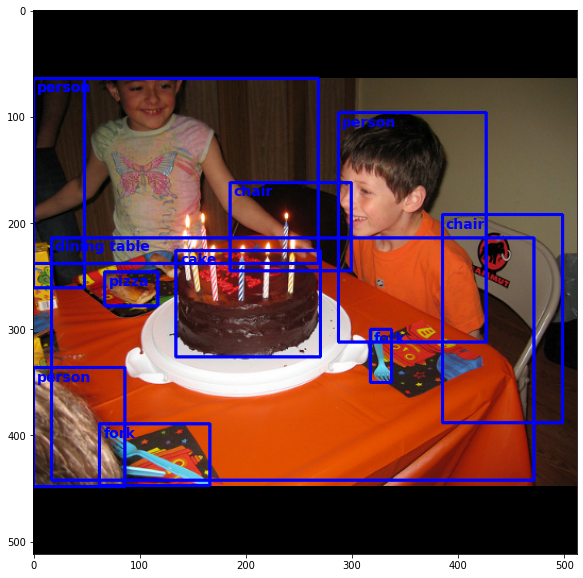

In [93]:
step_index = 1
batch_index = 2

img = batch_data[step_index]['image'][batch_index].numpy()
img = ((img + 1)/2 * 255).astype(np.uint8)

keep = batch_data[step_index]['bbox'][batch_index].numpy()[..., -1] > 0
x1, y1, w, h, label = batch_data[step_index]['bbox'][batch_index].numpy()[keep].T
x2 = x1 + w
y2 = y1 + h

fig, ax = plt.subplots(figsize=(10, 10))
for j in range(len(x1)):
    cv2.rectangle(img, (x1[j], y1[j]), (x2[j], y2[j]), (0, 0, 255), 2)
    ax.text(x1[j] + 3, y1[j] + 12, class_map[str(int(label[j]))], color=(0, 0, 1), fontsize=14, fontweight='bold')

ax.imshow(img)
print("id = {}".format(batch_data[step_index]['image_id'][batch_index].numpy()))

## Step 2 - `Network` construction

### Class and box subnets

We define the classification (class) subnet and regression (box) subnet. See Fig. 3 of the original paper.

In [96]:
from tensorflow.python.keras import layers, models, regularizers

def _classification_sub_net(num_classes, num_anchor=9):
    model = models.Sequential()
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    model.add(
        layers.Conv2D(num_classes * num_anchor,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer=tf.initializers.constant(np.log(1 / 99))))
    model.add(layers.Reshape((-1, num_classes)))  # the output dimension is [batch, #anchor, #classes]
    return model


def _regression_sub_net(num_anchor=9):
    model = models.Sequential()
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    model.add(
        layers.Conv2D(4 * num_anchor,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      kernel_regularizer=regularizers.l2(0.0001),
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01)))
    model.add(layers.Reshape((-1, 4)))  # the output dimension is [batch, #anchor, 4]
    return model

### RetinaNet

We use ResNet-50 as our backbone.

In [97]:
def RetinaNet(input_shape, num_classes, num_anchor=9):
    inputs = tf.keras.Input(shape=input_shape)
    # FPN
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=inputs, pooling=None)
    assert resnet50.layers[80].name == "conv3_block4_out"
    C3 = resnet50.layers[80].output
    assert resnet50.layers[142].name == "conv4_block6_out"
    C4 = resnet50.layers[142].output
    assert resnet50.layers[-1].name == "conv5_block3_out"
    C5 = resnet50.layers[-1].output
    P5 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0001))(C5)
    P5_upsampling = layers.UpSampling2D()(P5)
    P4 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0001))(C4)
    P4 = layers.Add()([P5_upsampling, P4])
    P4_upsampling = layers.UpSampling2D()(P4)
    P3 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0001))(C3)
    P3 = layers.Add()([P4_upsampling, P3])
    P6 = layers.Conv2D(256,
                       kernel_size=3,
                       strides=2,
                       padding='same',
                       name="P6",
                       kernel_regularizer=regularizers.l2(0.0001))(C5)
    P7 = layers.Activation('relu')(P6)
    P7 = layers.Conv2D(256,
                       kernel_size=3,
                       strides=2,
                       padding='same',
                       name="P7",
                       kernel_regularizer=regularizers.l2(0.0001))(P7)
    P5 = layers.Conv2D(256,
                       kernel_size=3,
                       strides=1,
                       padding='same',
                       name="P5",
                       kernel_regularizer=regularizers.l2(0.0001))(P5)
    P4 = layers.Conv2D(256,
                       kernel_size=3,
                       strides=1,
                       padding='same',
                       name="P4",
                       kernel_regularizer=regularizers.l2(0.0001))(P4)
    P3 = layers.Conv2D(256,
                       kernel_size=3,
                       strides=1,
                       padding='same',
                       name="P3",
                       kernel_regularizer=regularizers.l2(0.0001))(P3)
    # classification subnet
    cls_subnet = _classification_sub_net(num_classes=num_classes, num_anchor=num_anchor)
    P3_cls = cls_subnet(P3)
    P4_cls = cls_subnet(P4)
    P5_cls = cls_subnet(P5)
    P6_cls = cls_subnet(P6)
    P7_cls = cls_subnet(P7)
    cls_output = layers.Concatenate(axis=-2)([P3_cls, P4_cls, P5_cls, P6_cls, P7_cls])
    # localization subnet
    loc_subnet = _regression_sub_net(num_anchor=num_anchor)
    P3_loc = loc_subnet(P3)
    P4_loc = loc_subnet(P4)
    P5_loc = loc_subnet(P5)
    P6_loc = loc_subnet(P6)
    P7_loc = loc_subnet(P7)
    loc_output = layers.Concatenate(axis=-2)([P3_loc, P4_loc, P5_loc, P6_loc, P7_loc])
    return tf.keras.Model(inputs=inputs, outputs=[cls_output, loc_output])

### Loss functions

We use focal loss for classification and smooth L1 for regression loss. 

In [98]:
from fastestimator.op.tensorop import TensorOp

class RetinaLoss(TensorOp):
    def forward(self, data, state):
        anchorbox, cls_pred, loc_pred = data
        batch_size = anchorbox.shape[0]
        focal_loss, l1_loss, total_loss = [], [], []
        for idx in range(batch_size):
            single_loc_gt, single_cls_gt = anchorbox[idx][:, :-1], tf.cast(anchorbox[idx][:, -1], tf.int32)
            single_loc_pred, single_cls_pred = loc_pred[idx], cls_pred[idx]
            single_focal_loss, anchor_obj_idx = self.focal_loss(single_cls_gt, single_cls_pred)
            single_l1_loss = self.smooth_l1(single_loc_gt, single_loc_pred, anchor_obj_idx)
            focal_loss.append(single_focal_loss)
            l1_loss.append(single_l1_loss)
        focal_loss, l1_loss = tf.reduce_mean(focal_loss), tf.reduce_mean(l1_loss)
        total_loss = focal_loss + l1_loss
        return total_loss, focal_loss, l1_loss

    def focal_loss(self, single_cls_gt, single_cls_pred, alpha=0.25, gamma=2.0):
        # single_cls_gt shape: [num_anchor], single_cls_pred shape: [num_anchor, num_class]
        num_classes = single_cls_pred.shape[-1]
        # gather the objects and background, discard the rest
        anchor_obj_idx = tf.where(tf.greater_equal(single_cls_gt, 0))
        anchor_obj_bg_idx = tf.where(tf.greater_equal(single_cls_gt, -1))
        anchor_obj_count = tf.cast(tf.shape(anchor_obj_idx)[0], tf.float32)
        single_cls_gt = tf.one_hot(single_cls_gt, num_classes)
        single_cls_gt = tf.gather_nd(single_cls_gt, anchor_obj_bg_idx)
        single_cls_pred = tf.gather_nd(single_cls_pred, anchor_obj_bg_idx)
        single_cls_gt = tf.reshape(single_cls_gt, (-1, 1))
        single_cls_pred = tf.reshape(single_cls_pred, (-1, 1))
        # compute the focal weight on each selected anchor box
        alpha_factor = tf.ones_like(single_cls_gt) * alpha
        alpha_factor = tf.where(tf.equal(single_cls_gt, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = tf.where(tf.equal(single_cls_gt, 1), 1 - single_cls_pred, single_cls_pred)
        focal_weight = alpha_factor * focal_weight**gamma / anchor_obj_count
        cls_loss = tf.losses.BinaryCrossentropy(reduction='sum')(single_cls_gt,
                                                                 single_cls_pred,
                                                                 sample_weight=focal_weight)
        return cls_loss, anchor_obj_idx

    def smooth_l1(self, single_loc_gt, single_loc_pred, anchor_obj_idx, beta=0.1):
        # single_loc_gt shape: [num_anchor x 4], anchor_obj_idx shape:  [num_anchor x 4]
        single_loc_pred = tf.gather_nd(single_loc_pred, anchor_obj_idx)  #anchor_obj_count x 4
        single_loc_gt = tf.gather_nd(single_loc_gt, anchor_obj_idx)  #anchor_obj_count x 4
        anchor_obj_count = tf.cast(tf.shape(single_loc_pred)[0], tf.float32)
        single_loc_gt = tf.reshape(single_loc_gt, (-1, 1))
        single_loc_pred = tf.reshape(single_loc_pred, (-1, 1))
        loc_diff = tf.abs(single_loc_gt - single_loc_pred)
        cond = tf.less(loc_diff, beta)
        loc_loss = tf.where(cond, 0.5 * loc_diff**2 / beta, loc_diff - 0.5 * beta)
        loc_loss = tf.reduce_sum(loc_loss) / anchor_obj_count
        return loc_loss

### Learning rate

The learning rate has a warm up phase when step number is < 2k. After that, we reduce the learning rate by 10 at 120k and 160k respectively. The original batch size in the paper is 16 for 8 GPUs (2 per GPU). Here we are using 1GPU, with batch size 8. The learning rate should be proportional to the batch size, so in the learning rate function it is returning a learning divided by 2, accounting for our batch size.

In [99]:
def lr_fn(step):
    if step < 2000:
        lr = (0.01 - 0.0002) / 2000 * step + 0.0002
    elif step < 120000:
        lr = 0.01
    elif step < 160000:
        lr = 0.001
    else:
        lr = 0.0001
    return lr / 2  

In [100]:
model = fe.build(model_fn=lambda: RetinaNet(input_shape=(512, 512, 3), num_classes=90),
                 optimizer_fn=lambda: tf.optimizers.SGD(momentum=0.9))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

### Predict Box

In [101]:
class PredictBox(TensorOp):
    """Convert network output to bounding boxes.
    """
    def __init__(self,
                 inputs=None,
                 outputs=None,
                 mode=None,
                 input_shape=(512, 512, 3),
                 select_top_k=1000,
                 nms_max_outputs=100,
                 score_threshold=0.05):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.input_shape = input_shape
        self.select_top_k = select_top_k
        self.nms_max_outputs = nms_max_outputs
        self.score_threshold = score_threshold

        all_anchors, num_anchors_per_level = get_fpn_anchor_box(width=input_shape[1], height=input_shape[0])
        self.all_anchors = tf.convert_to_tensor(all_anchors)
        self.num_anchors_per_level = num_anchors_per_level

    def forward(self, data, state):
        pred = []

        # extract max score and its class label
        cls_pred, deltas, bbox = data
        batch_size = bbox.shape[0]
        labels = tf.cast(tf.argmax(cls_pred, axis=2), dtype=tf.int32)
        scores = tf.reduce_max(cls_pred, axis=2)


        # iterate over images
        for i in range(batch_size):
            # split batch into images
            labels_per_image = labels[i]
            scores_per_image = scores[i]
            deltas_per_image = deltas[i]

            selected_deltas_per_image = tf.constant([], shape=(0, 4))
            selected_labels_per_image = tf.constant([], dtype=tf.int32)
            selected_scores_per_image = tf.constant([])
            selected_anchor_indices_per_image = tf.constant([], dtype=tf.int32)

            end_index = 0
            # iterate over each pyramid level
            for j in range(self.num_anchors_per_level.shape[0]):
                start_index = end_index
                end_index += self.num_anchors_per_level[j]
                anchor_indices = tf.range(start_index, end_index, dtype=tf.int32)

                level_scores = scores_per_image[start_index:end_index]
                level_deltas = deltas_per_image[start_index:end_index]
                level_labels = labels_per_image[start_index:end_index]

                # select top k
                if self.num_anchors_per_level[j] >= self.select_top_k:
                    top_k = tf.math.top_k(level_scores, self.select_top_k)
                    top_k_indices = top_k.indices
                else:
                    top_k_indices = tf.subtract(anchor_indices, [start_index])

                # combine all pyramid levels
                selected_deltas_per_image = tf.concat(
                    [selected_deltas_per_image, tf.gather(level_deltas, top_k_indices)], axis=0)
                selected_scores_per_image = tf.concat(
                    [selected_scores_per_image, tf.gather(level_scores, top_k_indices)], axis=0)
                selected_labels_per_image = tf.concat(
                    [selected_labels_per_image, tf.gather(level_labels, top_k_indices)], axis=0)
                selected_anchor_indices_per_image = tf.concat(
                    [selected_anchor_indices_per_image, tf.gather(anchor_indices, top_k_indices)], axis=0)

            # delta -> (x1, y1, w, h)
            selected_anchors_per_image = tf.gather(self.all_anchors, selected_anchor_indices_per_image)
            x1 = (selected_deltas_per_image[:, 0] * selected_anchors_per_image[:, 2]) + selected_anchors_per_image[:, 0]
            y1 = (selected_deltas_per_image[:, 1] * selected_anchors_per_image[:, 3]) + selected_anchors_per_image[:, 1]
            w = tf.math.exp(selected_deltas_per_image[:, 2]) * selected_anchors_per_image[:, 2]
            h = tf.math.exp(selected_deltas_per_image[:, 3]) * selected_anchors_per_image[:, 3]
            x2 = x1 + w
            y2 = y1 + h

            # nms
            # filter out low score, and perform nms
            boxes_per_image = tf.stack([y1, x1, y2, x2], axis=1)
            nms_indices = tf.image.non_max_suppression(boxes_per_image,
                                                       selected_scores_per_image,
                                                       self.nms_max_outputs,
                                                       score_threshold=self.score_threshold)

            nms_boxes = tf.gather(boxes_per_image, nms_indices)
            final_scores = tf.gather(selected_scores_per_image, nms_indices)
            final_labels = tf.cast(tf.gather(selected_labels_per_image, nms_indices), dtype=tf.float32)

            # clip bounding boxes to image size
            x1 = tf.clip_by_value(nms_boxes[:, 1], clip_value_min=0, clip_value_max=self.input_shape[1])
            y1 = tf.clip_by_value(nms_boxes[:, 0], clip_value_min=0, clip_value_max=self.input_shape[0])
            w = tf.clip_by_value(nms_boxes[:, 3], clip_value_min=0, clip_value_max=self.input_shape[1]) - x1
            h = tf.clip_by_value(nms_boxes[:, 2], clip_value_min=0, clip_value_max=self.input_shape[0]) - y1

            image_results = tf.stack([x1, y1, w, h, final_labels, final_scores], axis=1)
            pred.append(image_results)
            
        return pred

In [102]:
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

network = fe.Network(ops=[
    ModelOp(model=model, inputs="image", outputs=["cls_pred", "loc_pred"]),
    RetinaLoss(inputs=["anchorbox", "cls_pred", "loc_pred"], outputs=["total_loss", "focal_loss", "l1_loss"]),
    UpdateOp(model=model, loss_name="total_loss"),
    PredictBox(inputs=["cls_pred", "loc_pred", "bbox"], outputs="pred", mode="eval")
])

## Step 3 - `Estimator` definition and training

In [104]:
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import MeanAveragePrecision

estimator = fe.Estimator(
    pipeline=pipeline,
    network=network,
    epochs=epochs,
    max_train_steps_per_epoch=max_train_steps_per_epoch,
    max_eval_steps_per_epoch=max_eval_steps_per_epoch,
    traces=[
        LRScheduler(model=model, lr_fn=lr_fn),
        BestModelSaver(model=model, save_dir=save_dir, metric='mAP', save_best_mode="max"),
        MeanAveragePrecision(num_classes=90)
    ],
    monitor_names=["l1_loss", "focal_loss"])

In [ ]:
estimator.fit()

## Inference

### Load trained model and reconstruct `Network`

In [198]:
import os

weights_path = os.path.join(save_dir, "model1_best_mAP.h5")

In [199]:
model = fe.build(model_fn=lambda: RetinaNet(input_shape=(512, 512, 3), num_classes=90),
                 optimizer_fn=None,
                 model_name="retinanet",
                 weights_path=weights_path)

In [200]:
network = fe.Network(ops=[
    ModelOp(model=model, inputs="image", outputs=["cls_pred", "loc_pred"]),
    PredictBox(inputs=["cls_pred", "loc_pred", "bbox"], outputs="pred", mode="infer")
])

### Feed data

We randomly select 4 images and visualize the model predictions.

In [255]:
num_images = 4

In [256]:
np.random.seed(379)
selected = np.random.randint(len(eval_ds), size=num_images).tolist()
data = [pipeline.transform(eval_ds[i], mode="infer") for i in selected]
im = np.array([item['image'][0] for item in data])
pad = max(item['bbox'][0].shape[0] for item in data)
bo = np.array([
    np.pad(item['bbox'][0], ((0, pad - item['bbox'][0].shape[0]), (0, 0)), mode='constant', constant_values=0)
    for item in data
])

In [257]:
network_out = network.transform({'image': im, 'bbox': bo}, mode="infer")

### Visualize predictions

[0.9880271  0.6860561  0.34332335 0.3304865 ]
['airplane', 'truck', 'person', 'person']
[0.99191636 0.0548539  0.05163975 0.99191636]
['bear', 'bear', 'bear', 'bear']
[0.870187   0.50000274 0.12686375 0.09993405]
['vase', 'cup', 'bowl', 'vase']
[0.83461    0.78291625 0.7454702  0.46012864]
['laptop', 'cat', 'chair', 'cell phone']


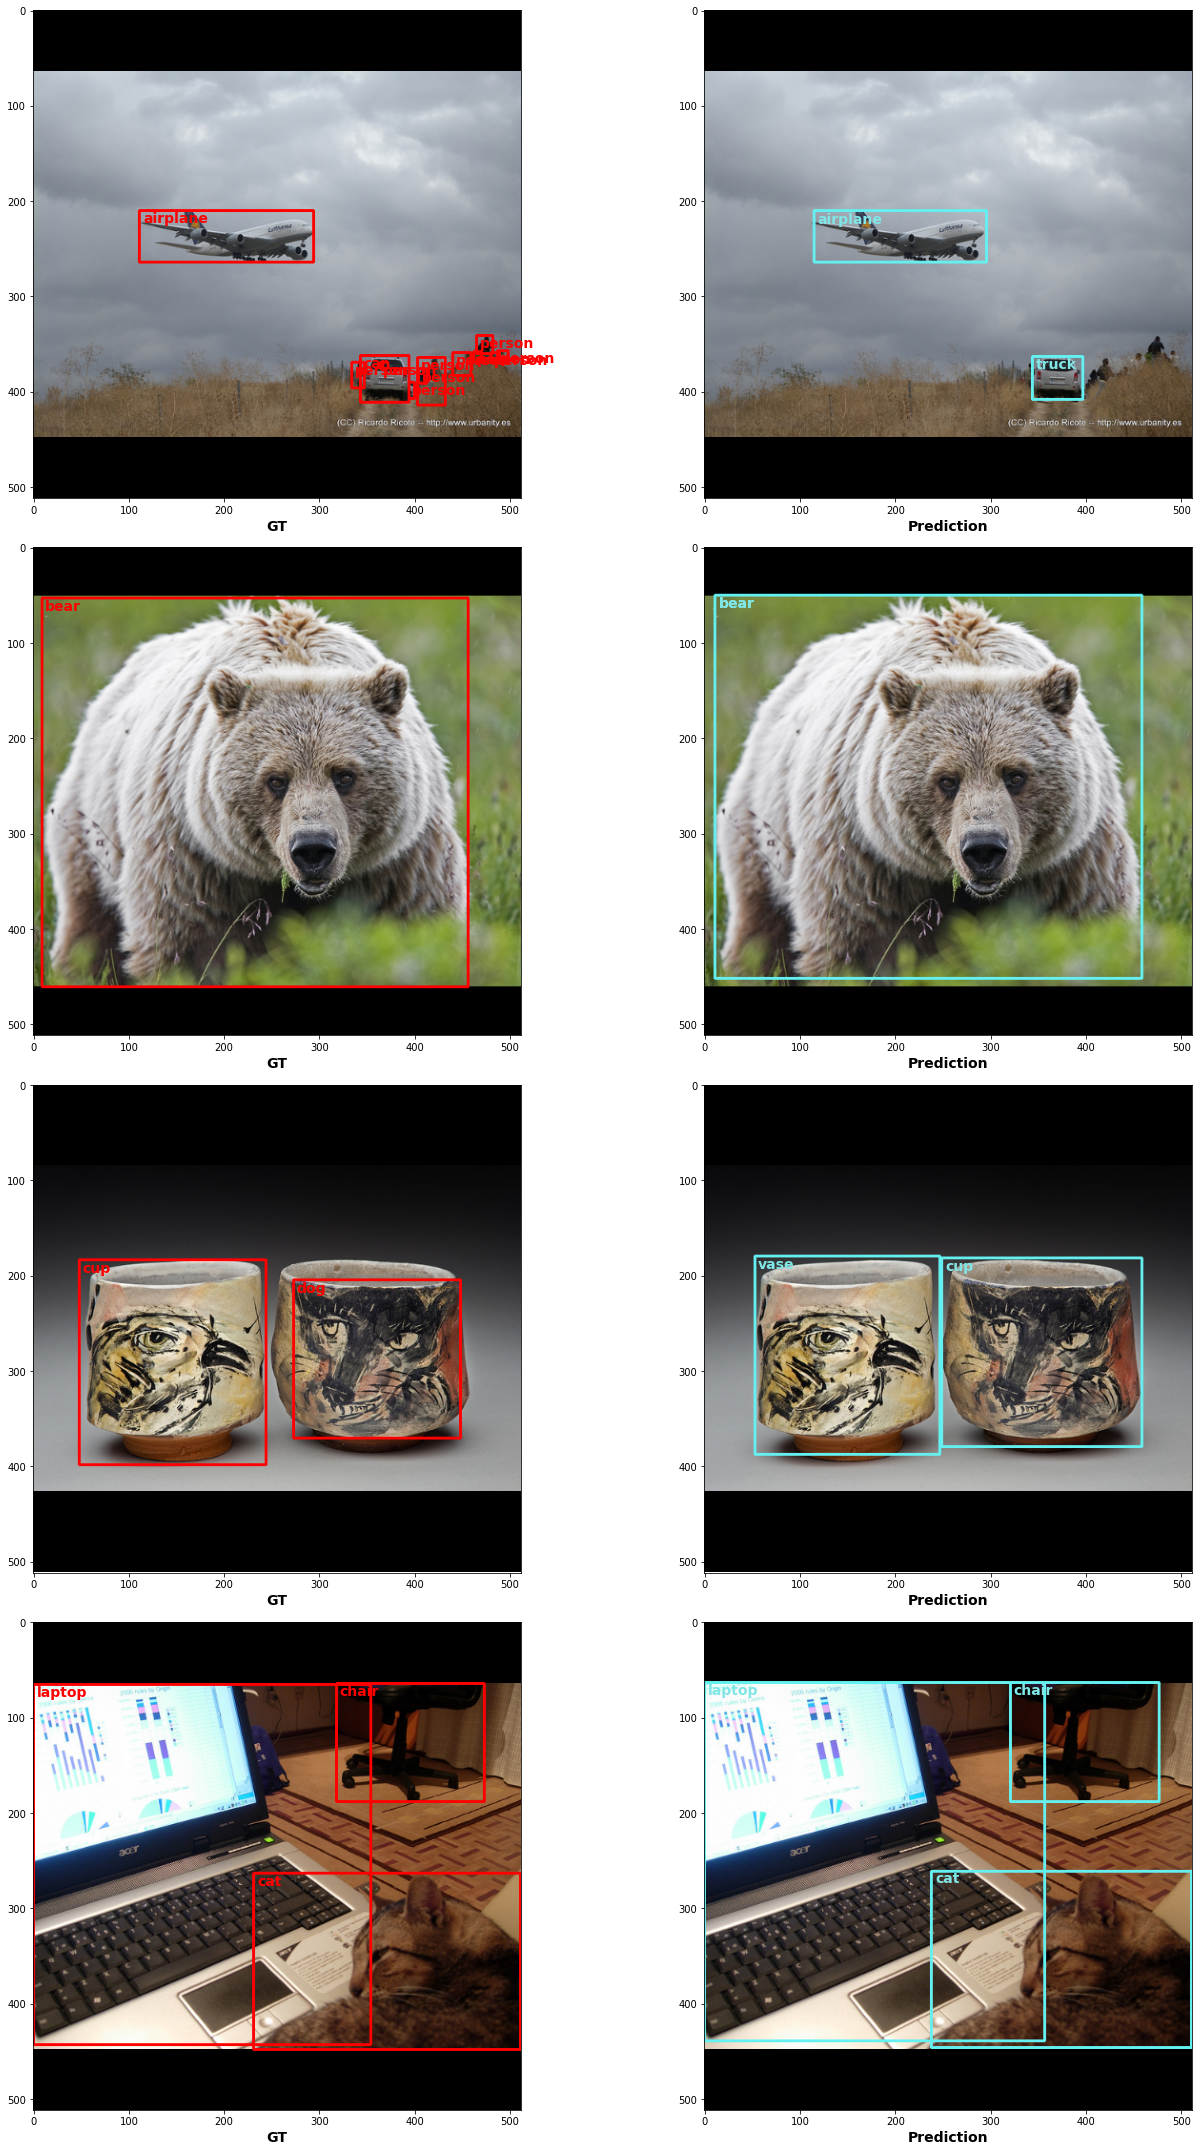

In [260]:
fig, ax = plt.subplots(num_images, 2, figsize=(20, 30))
for batch_index in range(num_images):
    img = network_out['image'].numpy()[batch_index, ...]
    img = ((img + 1) / 2 * 255).astype(np.uint8)

    img2 = img.copy()

    keep = network_out['bbox'][batch_index].numpy()[..., -1] > 0
    gt_x1, gt_y1, gt_w, gt_h, gt_label = network_out['bbox'][batch_index].numpy()[keep].T
    gt_x2 = gt_x1 + gt_w
    gt_y2 = gt_y1 + gt_h

    scores = network_out['pred'][batch_index].numpy()[..., -1]
    labels = network_out['pred'][batch_index].numpy()[..., -2]
    keep = scores > 0.5
    x1, y1, w, h, label, _ = network_out['pred'][batch_index].numpy()[keep].T
    x2 = x1 + w
    y2 = y1 + h

    for i in range(len(gt_x1)):
        cv2.rectangle(img, (gt_x1[i], gt_y1[i]), (gt_x2[i], gt_y2[i]), (255, 0, 0), 2)
        ax[batch_index, 0].set_xlabel('GT', fontsize=14, fontweight='bold')
        ax[batch_index, 0].text(gt_x1[i] + 3,
                   gt_y1[i] + 12,
                   class_map[str(int(gt_label[i]))],
                   color=(1, 0, 0),
                   fontsize=14,
                   fontweight='bold')

    for j in range(len(x1)):
        cv2.rectangle(img2, (x1[j], y1[j]), (x2[j], y2[j]), (100, 240, 240), 2)
        ax[batch_index, 1].set_xlabel('Prediction', fontsize=14, fontweight='bold')
        ax[batch_index, 1].text(x1[j] + 3, y1[j] + 12, class_map[str(int(label[j]))], color=(0.5, 0.9, 0.9), fontsize=14, fontweight='bold')

    ax[batch_index, 0].imshow(img)
    ax[batch_index, 1].imshow(img2)
    print(scores)
    print(list(map(class_map.get, labels.astype(int).astype(str))))

plt.tight_layout()